### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** до 30 апреля 2018, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 30 апреля, -4 балла после 06:00 7 мая, -6 баллов после 06:00 14 мая, -8 баллов после 06:00 21 мая

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush


Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (3 балла)
Разберитесь в коде MyDecisionTreeClassifier, который уже частично реализован. Допишите код там, где написано "Ваш код". Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn. Точность проверяется на wine и Speed Dating Data.

###### Задание 2 (3 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine и Speed Dating Data. 
Для этого используем numpy.

###### Задание 3 (2 балла)
Добавьте функционал, который определяет значения feature importance. Выведите 10 главных фичей под пунктом Задание 4 (уже написано ниже) для MyDecisionTreeClassifier и DecisionTreeClassifier так, чтобы сразу были видны выводы и по MyDecisionTreeClassifier, и по DecisionTreeClassifier. Используем данные Speed Dating Data.

###### Задание 4 (2 балла)
С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 5 (уже написано ниже)


**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw3.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
%load_ext pycodestyle_magic

In [71]:
#%%pycodestyle


class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None,
                 sufficient_share=1.0, criterion='gini', max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features is None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    def __gini(self, l_c, l_s, r_c, r_s):
        return l_s * (1 - (l_c ** 2).sum(
            axis=1)) + r_s * (1 - (r_c ** 2).sum(axis=1))

    def __entropy(self, l_c, l_s, r_c, r_s):
        return - l_s * (l_c * np.log(l_c + 1e-16)).sum(
            axis=1) - r_s * (r_c * np.log(r_c + 1e-16)).sum(axis=1)

    def __misclass(self, l_c, l_s, r_c, r_s):
        return l_s * (1 - np.max(
            l_c, axis=1)) + r_s * (1 - np.max(r_c, axis=1))

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:np.int(np.sqrt(n_feature))]

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:np.int(np.log2(n_feature))]

    def __get_feature_ids_N(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):

        y_len = len(y)
        g_min = y_len

        y_bin = np.bincount(y, minlength=self.num_class)

        x_ff, y_ff = self.__sort_samples(x, y)

        X_IND = np.where(x_ff[:-1] != x_ff[1:])[0] + 1

        if len(X_IND) < 1:
            split = (x_ff[0] - 0.1, g_min)
            return split

        steps = np.arange(1, y_len)
        matr = np.zeros((y_len-1, self.num_class))
        matr[steps-1, y_ff[:-1]] = 1
        class_steps = np.cumsum(matr, axis=0)

        l_c = class_steps[X_IND-1]
        r_c = y_bin.reshape(1, -1) - l_c

        r_s = r_c.sum(axis=1)
        l_s = y_len - r_s

        l_c = l_c / l_s.reshape(-1, 1)
        r_c = r_c / r_s.reshape(-1, 1)

        gains = self.G_function(l_c, l_s, r_c, r_s)

        best_k = gains.argmin()
        g_min = gains[best_k]

        left = x_ff[X_IND[best_k-1]] if best_k > 0 else x_ff[0]

        best_th = (left + x_ff[X_IND[best_k]]) / 2

        split = (best_th, g_min)

        return split

    def __fit_node(self, x, y, node_id, depth):

        y_bin = np.bincount(y, minlength=self.num_class)

        y_prob = y_bin / len(y)

        condition = False

        # в листе 100% одного класса
        condition |= len(set(y)) <= 1

        # глубина дерева
        condition |= depth == self.max_depth

        # количество элементов в листе
        condition |= len(y) < self.min_samples_split

        if condition:
            self.tree[node_id] = [self.__class__.LEAF_TYPE,
                                  np.argmax(y_bin), y_prob]
        else:
            feature_ids = self.get_feature_ids(x.shape[1])

            buf = np.apply_along_axis(lambda u: self.__find_threshold(u, y),
                                      0, x[:, feature_ids])
            arg = buf[1].argmin()
            best_split = [arg, buf[0, arg], buf[1, arg]]

            best_feature = feature_ids[best_split[0]]

            Gain_S = (self.G_function(y_prob.reshape(1, -1),
                                      np.array([len(y)]), np.array([[0]]),
                                      np.array([0])) - best_split[2]) / len(y)

            if Gain_S < 1e-16:
                self.tree[node_id] = [self.__class__.LEAF_TYPE,
                                      np.argmax(y_bin), y_prob]

            else:

                self.feature_importances_[best_feature] += Gain_S * len(y)

                x_l, x_r, y_l, y_r = self.__div_samples(x, y,
                                                        best_feature,
                                                        best_split[1])

                self.tree[node_id] = [self.__class__.NON_LEAF_TYPE,
                                      best_feature, best_split[1]]

                self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
                self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)

    def fit(self, x, y):
        self.time_check = 0
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y.astype('int64'), 0, 0)
        self.feature_importances_ /= self.feature_importances_.sum()

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [72]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [105]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

## Проверка скорости работы на wine

In [106]:
import time

In [107]:
%time clf.fit(X_train, y_train)

CPU times: user 2.38 ms, sys: 947 µs, total: 3.32 ms
Wall time: 2.96 ms


In [108]:
%time my_clf.fit(X_train, y_train)

CPU times: user 26.1 ms, sys: 2.91 ms, total: 29 ms
Wall time: 26.4 ms


## Проверка качества работы на wine

In [109]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.9440559440559441

In [110]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.9440559440559441

## Подготовка данных Speed Dating Data 

In [111]:
df = pd.read_csv('./speed-dating-experiment/Speed Dating Data.csv', encoding='latin1')

df = df.iloc[:, :97]
df = df.drop(['id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner',
              'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun',
              'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o', 'field', 'undergra',
              'from', 'zipcode', 'career', 'sports', 'tvsports', 'exercise', 'dining',
              'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
              'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'expnum'], axis=1)

df = df.dropna(subset=['age'])

df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = pd.get_dummies(df, columns=['field_cd'], prefix='field_cd', prefix_sep='=')

df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df['mn_sat'] = df['mn_sat'].fillna(-999)

df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df['tuition'] = df['tuition'].fillna(-999)

df = pd.get_dummies(df, columns=['race'], prefix='race', prefix_sep='=')

df = df.dropna(subset=['imprelig', 'imprace'])

df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)

df = df.dropna(subset=['date'])

df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df = pd.get_dummies(df, columns=['career_c'], prefix='career_c', prefix_sep='=')

cols = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
df.loc[:, 'temp_totalsum'] = df.loc[:, cols].sum(axis=1)
df.loc[:, cols] = (df.loc[:, cols].T/df.loc[:, 'temp_totalsum'].T).T * 100

cols = ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
df.loc[:, 'temp_totalsum'] = df.loc[:, cols].sum(axis=1)
df.loc[:, cols] = (df.loc[:, cols].T/df.loc[:, 'temp_totalsum'].T).T * 100

df = df.drop(['temp_totalsum'], axis=1)

for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)
    
df = df.drop(['wave'], axis=1)

df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

data = df_male.join(df_female.set_index('iid_f'), how='inner', on='pid')

In [112]:
ids = ['iid', 'pid']
target = 'match'
features = [col for col in data.columns if col not in ids + [target]]

In [116]:
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data[target].values,
                                                    test_size=0.2, stratify=data[target].values)

## Проверка скорости работы на Speed Dating Data 

In [121]:
%time clf.fit(X_train, y_train)

CPU times: user 96.1 ms, sys: 2.35 ms, total: 98.5 ms
Wall time: 461 ms


In [123]:
%time my_clf.fit(X_train, y_train)

CPU times: user 4.49 s, sys: 23.9 ms, total: 4.52 s
Wall time: 4.52 s


## Проверка качества работы на Speed Dating Data

In [124]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.5224331475820402

In [125]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.526045357902197

## Задание 3

In [126]:
features = np.array(features)

def models_compare(models, names, top_k):
    global features

    fig, ax = plt.subplots(1, 2, figsize=(10, top_k * 3/5))
    fig.subplots_adjust(wspace=0.5)
    for k, model in enumerate(models):
        imp = model.feature_importances_
        ind = imp.argsort()[::-1][:top_k]
        ind = ind[::-1]
        ax[k].barh(y=features[ind], width=imp[ind], height=0.6)
        ax[k].grid()
        ax[k].set_title(names[k])
    plt.show()

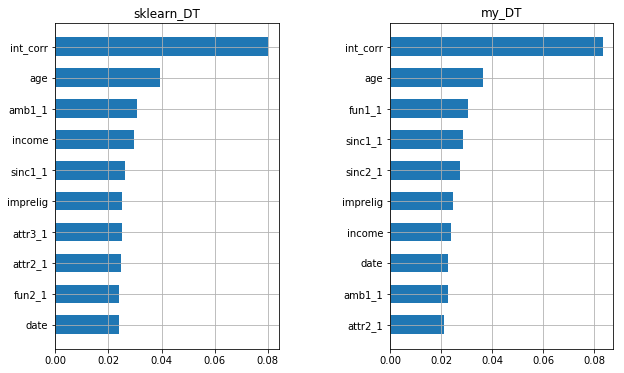

In [127]:
models_compare([clf, my_clf],['sklearn_DT', 'my_DT'], top_k=10)

## Задание 4

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

In [ ]:
%%time
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(2, 10),
    'min_samples_split': randint(2, 10)}

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

model = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=200,
                                   n_jobs=-1, cv=cv, scoring='f1', random_state=0)
# А дальше, просто .fit()
random_search.fit(X_train, y_train)

In [ ]:
print('Best params:', random_search.best_params_)
print('Best score:', random_search.best_score_)

### EOF